[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nahuelalmeira/midnight/blob/main/notebooks/notebook.ipynb)

In [14]:
# If in colab, uncomment next line

# !pip install --quiet git+https://github.com/nahuelalmeira/midnight

### General Config

Standard imports

In [15]:
# Graphics
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set()
sns.set_context("talk")
matplotlib.rcParams["figure.figsize"] = (12, 8)

Module imports

In [16]:
from midnight.player import Player
from midnight.game import Game
from midnight.strategy import (
    ConservativeStrategy,
    MiddleStrategy,
    AlwaysConservativeStrategy,
    AlwaysMiddleStrategy,
)

Auxiliary functions

In [17]:
def compute_ccdf_dataframe(samples):
    """
    Compute Complementary Cumulative Distribution Function
    and store values in a DataFrame.
    """
    data = {}
    for start_dice, sample in samples.items():
        ccdf = (
            sample.value_counts(normalize=True)
            .sort_index(ascending=False)
            .drop(0, errors="ignore")
            .cumsum()
        )
        data[str(start_dice)] = ccdf
    df = pd.DataFrame(data)
    df.index.name = "Score"
    return df.melt(
        value_name="Probability", var_name="Dice selection", ignore_index=False
    ).reset_index()

### Example

The `.show_example` method allows the user to perform a simple simulation and visualize the decisions taken by the strategy. If no parameters are given, the simulation starts by rolling all six dice.

In [18]:
MiddleStrategy().show_example()

,Kept dice,Roll,New dice
0,[],"[1, 6, 1, 3, 5, 4]","[1, 4, 6]"
1,"[1, 4, 6]","[1, 6, 3]",[6]
2,"[1, 4, 6, 6]","[6, 6]","[6, 6]"


The simulation can be started in the middle of a play, that is, when the player has already kept some dice.

In [19]:
MiddleStrategy().show_example(start_dice=[6, 4])

,Kept dice,Roll,New dice
0,"[6, 4]","[2, 5, 6, 3]",[6]
1,"[6, 4, 6]","[4, 2, 6]",[6]
2,"[6, 4, 6, 6]","[5, 2]",[5]
3,"[6, 4, 6, 6, 5]",[3],[3]


Also, the first roll can be also defined.

In [20]:
MiddleStrategy().show_example(start_roll=[1, 2, 3, 4, 4, 6])

,Kept dice,Roll,New dice
0,[],"[1, 2, 3, 4, 4, 6]","[1, 4, 6]"
1,"[1, 4, 6]","[4, 2, 5]",[5]
2,"[1, 4, 6, 5]","[5, 3]",[5]
3,"[1, 4, 6, 5, 5]",[3],[3]


Finaly, both parameters can be combined to give more flexibility to the simulation.

In [21]:
MiddleStrategy().show_example(start_dice=[6, 4], start_roll=[1, 2, 3, 4])

,Kept dice,Roll,New dice
0,"[6, 4]","[1, 2, 3, 4]",[1]
1,"[6, 4, 1]","[6, 6, 2]","[6, 6]"
2,"[6, 4, 1, 6, 6]",[5],[5]


Note that the length of start_dice plus the length of start_roll must be equal to 6, otherwise the method will raise an exception.

In [22]:
# Uncomment the next line to see the exception message.

# MiddleStrategy().show_example(start_dice=[6, 4], start_roll=[1, 2, 4])

### Comparison of strategies

Basic strategies can be compared by sampling a large number of plays and comparing the scores.

In [23]:
nsamples = 10000
sample_conservative = pd.Series(ConservativeStrategy.sample(nsamples))
sample_middle = pd.Series(MiddleStrategy.sample(nsamples))
samples = {"Conservative": sample_conservative, "Middle": sample_middle}

One way of performing the comparison is to look at the score probability distribution $p(x)$. For example, the next figre compares the Middle against the Conservative strategies.

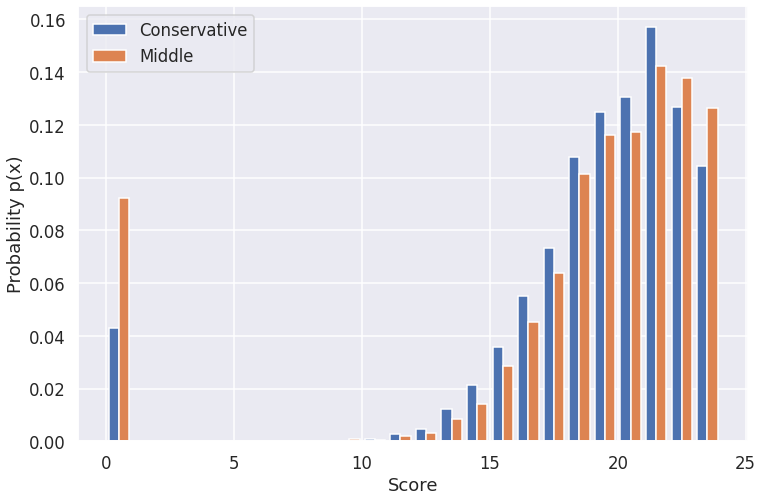

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("Score")
ax.set_ylabel("Probability p(x)")
ax.hist(samples.values(), bins=range(0, 25), density=True, label=list(samples.keys()))
plt.legend()
plt.show()

From the graph we see that the Conservative strategy beats the Middle strategy for scores under 21, and the opposite occures for scores higher than this value.

Other way, perhaps more intuitive, is to look at the score complementary cumulative distribution function (CCDF), defined as

$$
P(x) = p(X\geq x) = \text{Probability of scoring } x \text{ or more.}
$$

In other words, $P(x)$ gives the tie or win probability against each score $x$.

Again, we compare Conservative Vs. Middle

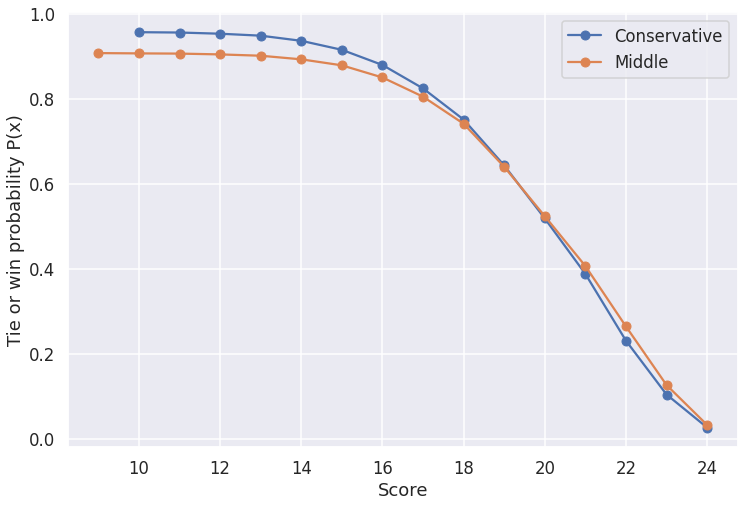

In [25]:
fig, ax = plt.subplots()
for name, sample in samples.items():
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0)
        .cumsum()
        .plot(marker="o", xlabel="Score", ylabel="Tie or win probability P(x)", label=name, ax=ax)
    )
ax.legend()
plt.show()

From the CCDF, we can see that the Middle strategy should be chosen against the Conservative one for scores above 19.

### Full game simulation

The package allows to simulate a full game scenario, including bets and players with different strategies

In [26]:
n_rounds = 10000
n_players = 2
initial_stake = 1000

print("-----------------")
print("Game settings")
print(f"Number of players: {n_players}")
print(f"Number of rounds: {n_rounds}")
print(f"Initial stake: {initial_stake}")
print("-----------------")
print()

Player.reset_counter()
game = Game(n_rounds=n_rounds)
player1 = Player(
    strategy=AlwaysConservativeStrategy(), initial_stake=initial_stake
)
game.add_player(player1)
player2 = Player(
    strategy=AlwaysMiddleStrategy(), initial_stake=initial_stake
)
game.add_player(player2)

# Play game
game.play()

print("-----------------")
print("Game stats")
stats = game.get_game_stats()
display(stats.head(10))
print("-----------------")
print()
print(f"Final relative stakes: {game.relative_stakes}")
print()

print("-----------------")
print("Scores")
scores = game.get_all_scores()
display(scores.head())
print("-----------------")
print()

print("-----------------")
print("Qualification rate per player:")
display((scores > 0).mean())
print("-----------------")
print()

print("-----------------")
print("Win rate per player:")
display(stats["WINNER"].value_counts(normalize=True))
print("-----------------")
print()


-----------------
Game settings
Number of players: 2
Number of rounds: 10000
Initial stake: 1000
-----------------

-----------------
Game stats


,ROUND,POT,WINNER,SCORES
0,0,2,Player2,"[18, 22]"
1,1,2,Tie,"[19, 19]"
2,2,4,Player1,"[21, 20]"
3,3,2,Player1,"[22, 21]"
4,4,2,Player1,"[23, 17]"
5,5,2,Player1,"[18, 16]"
6,6,2,Player2,"[15, 24]"
7,7,2,Player2,"[14, 18]"
8,8,3,Player2,"[0, 23]"
9,9,2,Tie,"[20, 20]"


-----------------

Final relative stakes: [428, -428]

-----------------
Scores


,Player1,Player2
0,18,22
1,19,19
2,21,20
3,22,21
4,23,17


-----------------

-----------------
Qualification rate per player:


Player1    0.9583
Player2    0.9065
dtype: float64

-----------------

-----------------
Win rate per player:


Player2    0.456
Player1    0.447
Tie        0.097
Name: WINNER, dtype: float64

-----------------



### First roll choice comparison

In [27]:
nsamples = int(1e4)
samples = {"Middle": {}}

In [59]:
start_dice_cases = [
    (6,), (6, 4), (6, 4, 1), (6, 6), (6, 6, 4),
    (6, 6, 6), (6, 6, 1), (6, 1), (6, 6, 6, 1), (4,),
    (6, 6, 1, 4, 5)
]
for i, start_dice in enumerate(start_dice_cases):
    print(i, start_dice)
    if start_dice in samples["Middle"]:
        continue
    samples["Middle"][start_dice] = pd.Series(
        MiddleStrategy.sample(nsamples, start_dice=start_dice)
    )

0 (6,)
1 (6, 4)
2 (6, 4, 1)
3 (6, 6)
4 (6, 6, 4)
5 (6, 6, 6)
6 (6, 6, 1)
7 (6, 1)
8 (6, 6, 6, 1)
9 (4,)
10 (6, 6, 1, 4, 5)


In [36]:
df = compute_ccdf_dataframe(samples["Middle"])

fig = px.line(
    df, x="Score", y="Probability", color="Dice selection",
    markers=True, height=600, width=1400
)
fig.update_layout(
    font_size=18,
    yaxis_title="Tie or win probability"
)
fig.show()

#### Examples

In [46]:
def first_roll_example(dice, choices):
    print("Roll", dice)
    print("Conservative choice:", sorted(ConservativeStrategy().play([], dice)))
    print("Middle choice:      ", sorted(MiddleStrategy().play([], dice)))
    _, ax = plt.subplots()
    for start_dice in choices:
        sample = samples["Middle"][start_dice]
        (
            sample.value_counts(normalize=True)
            .sort_index(ascending=False)
            .drop(0, errors="ignore")
            .cumsum()
            .plot(
                marker="o",
                xlabel="Score",
                ylabel="Tie or win probability",
                label=str(start_dice),
                ax=ax
            )
        )
    ax.legend()
    plt.show()

Roll [6, 4, 3, 3, 3, 3]
Conservative choice: [4]
Middle choice:       [4, 6]


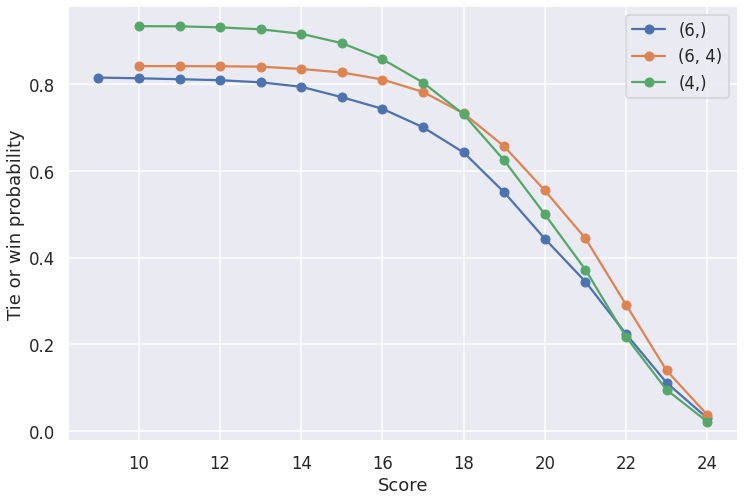

In [53]:
dice = [6, 4, 3, 3, 3, 3]
choices = [(6,), (6, 4), (4,)]
first_roll_example(dice, choices)

Roll [6, 4, 1, 3, 3, 3]
Conservative choice: [1, 4, 6]
Middle choice:       [1, 4, 6]


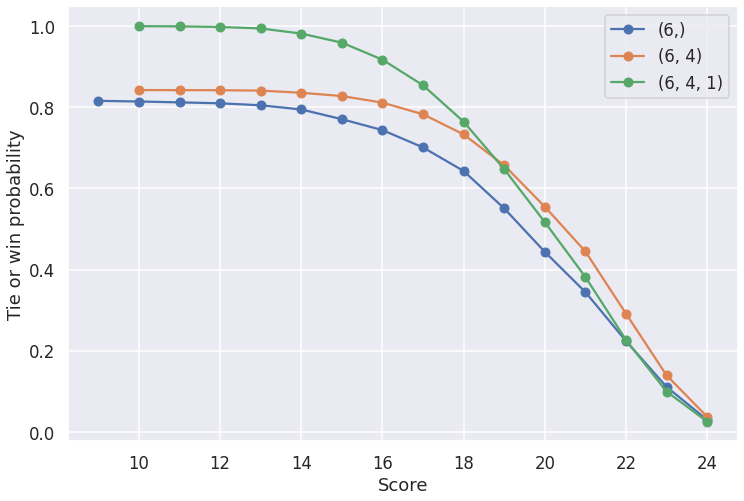

In [54]:
dice = [6, 4, 1, 3, 3, 3]
choices = [(6,), (6, 4), (6, 4, 1)]
first_roll_example(dice, choices)

Roll [6, 6, 4, 3, 3, 3]
Conservative choice: [4]
Middle choice:       [4, 6]


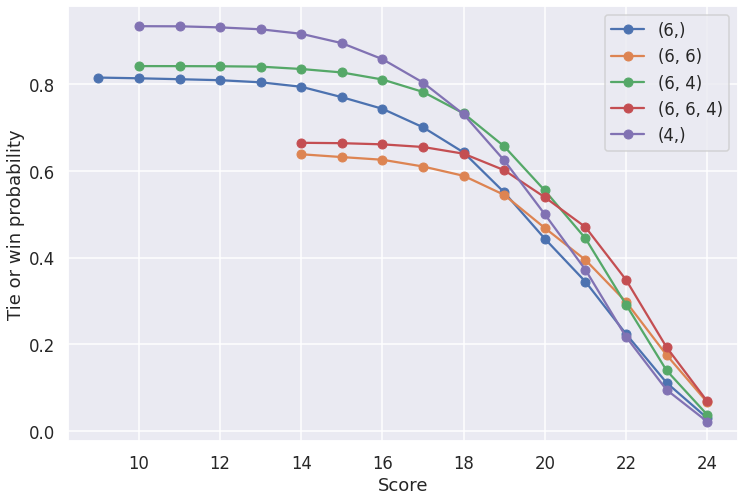

In [57]:
dice = [6, 6, 4, 3, 3, 3]
choices = [(6,), (6, 6), (6, 4), (6, 6, 4), (4,)]
first_roll_example(dice, choices)

Roll [6, 6, 1, 4, 5, 4]
Conservative choice: [1, 4, 4, 5, 6, 6]
Middle choice:       [1, 4, 4, 5, 6, 6]


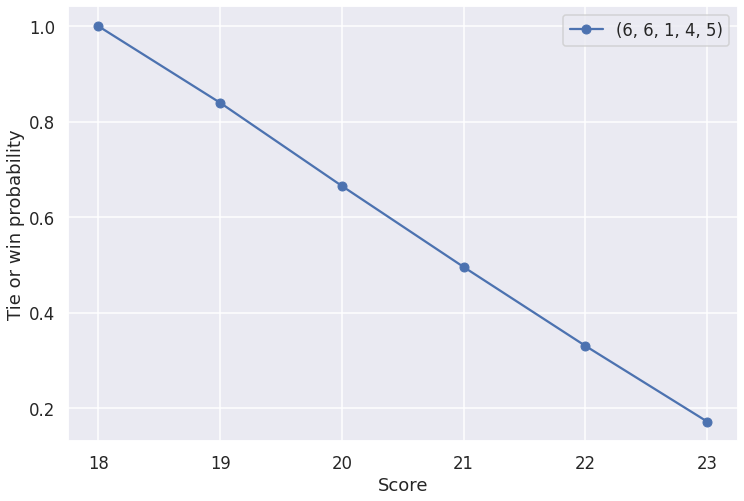

In [60]:
dice = [6, 6, 1, 4, 5, 4]
choices = [(6, 6, 1, 4, 5)]
first_roll_example(dice, choices)

Roll [6, 6, 6, 1, 3, 3]
Conservative choice: [1]
Middle choice:       [1, 6]


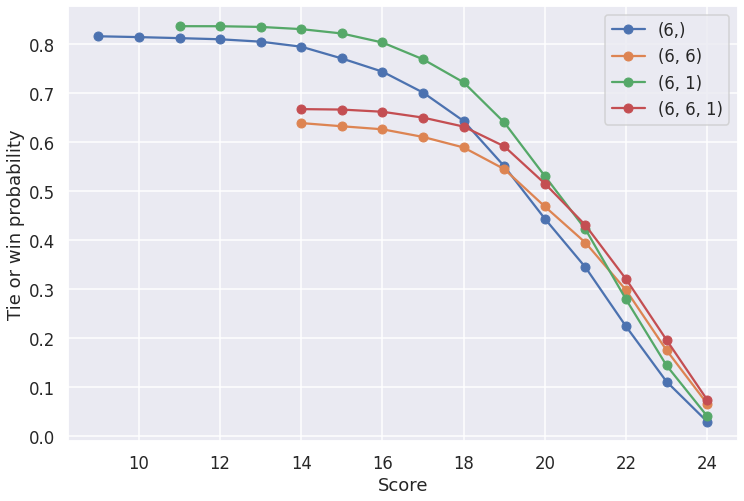

In [61]:
dice = [6, 6, 6, 1, 3, 3]
choices = [(6,), (6, 6), (6, 1), (6, 6, 1)]
first_roll_example(dice, choices)